In [1]:
from sentence_transformers import SentenceTransformer, util
import pandas as pd
import xml.etree.ElementTree as ET
from tqdm import tqdm
tqdm.pandas()
import matplotlib.pyplot as plt
import os
import numpy as np

In [2]:
root_path = "./assets"
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')  

climate_keywords_en = [
    "climate change", "global warming", "greenhouse gas", "carbon emissions", "decarbonization",
    "carbon footprint", "co2", "methane", "sea level rise", "glacier melt", "drought", "flood",
    "storm", "heatwave", "resilience", "adaptation", "mitigation", "climate policy", "renewable energy",
    "energy efficiency", "sustainable agriculture", "climate finance", "carbon neutral", "net zero",
    "emissions reduction", "deforestation", "reforestation", "afforestation", "biodiversity loss",
    "ecosystem collapse", "climate migration", "climate risk", "climate action", "nature-based solutions",
    "climate scenario", "climate model", "extreme weather", "carbon pricing", "carbon tax", "GHG inventory",
    "permafrost", "ocean acidification", "desertification", "weather variability", "climate adaptation"
]

climate_keywords_fr = [
    "changement climatique", "réchauffement climatique", "gaz à effet de serre", "émissions de carbone",
    "décarbonation", "empreinte carbone", "co2", "méthane", "élévation du niveau de la mer",
    "fonte des glaciers", "sécheresse", "inondation", "tempête", "vague de chaleur", "résilience",
    "adaptation", "atténuation", "politique climatique", "énergie renouvelable", "efficacité énergétique",
    "agriculture durable", "financement climatique", "carboneutralité", "zéro émission nette",
    "réduction des émissions", "déforestation", "reforestation", "afforestation", "perte de biodiversité",
    "effondrement des écosystèmes", "migration climatique", "risque climatique", "action climatique",
    "solutions fondées sur la nature", "scénario climatique", "modèle climatique", "événements climatiques extrêmes",
    "tarification du carbone", "taxe carbone", "inventaire GES", "pergélisol", "acidification des océans",
    "désertification", "variabilité climatique", "adaptation au climat"
]

keyword_embeddings_en = model.encode(climate_keywords_en, convert_to_tensor=True)
keyword_embeddings_fr = model.encode(climate_keywords_fr, convert_to_tensor=True)


In [3]:
def compute_climate_score(text, keyword_embeddings):
    if not isinstance(text, str) or len(text.strip()) == 0:
        return 0.0
    text_embedding = model.encode(text, convert_to_tensor=True)
    cosine_scores = util.cos_sim(text_embedding, keyword_embeddings)
    return float(np.max(cosine_scores.numpy()))

def compute_climate_score_fallback(row, keyword_embeddings):
    text = row['Projet.Resume.Francais']
    if pd.isna(text) or len(str(text).strip()) == 0:
        text = row['Projet.Titre.Francais']
    return compute_climate_score(text, keyword_embeddings)

# DGPIE

In [5]:
df = pd.read_csv(os.path.join(root_path,"anr-dgpie-depuis-2010-projets-finances-20250602-projets.csv"),on_bad_lines="warn", sep=";")

In [6]:
print(df.shape)
print(df.columns)

(2456, 8)
Index(['Projet.Code_Decision_ANR', 'Projet.Date_debut', 'Action.Edition',
       'Action.Titre.Francais', 'Projet.Acronyme', 'Projet.Titre.Francais',
       'Projet.Resume.Francais', 'Projet.Aide_allouee'],
      dtype='object')


In [7]:
for col in df.columns :
    print(f"{col} : {df.iloc[150][col]}")

print('--------------------------------')
nan_ratio = df.isna().mean().sort_values(ascending=False)
print(nan_ratio)


Projet.Code_Decision_ANR : ANR-24-GURE-0013
Projet.Date_debut : nan
Action.Edition : 2024
Action.Titre.Francais : GURE
Projet.Acronyme : UNINOVIS
Projet.Titre.Francais : UNINOVIS DATA FOR L.I.F.E.
Projet.Resume.Francais : nan
Projet.Aide_allouee : 0.0
--------------------------------
Projet.Resume.Francais      0.376221
Projet.Date_debut           0.187704
Action.Edition              0.000000
Projet.Code_Decision_ANR    0.000000
Action.Titre.Francais       0.000000
Projet.Acronyme             0.000000
Projet.Titre.Francais       0.000000
Projet.Aide_allouee         0.000000
dtype: float64


In [8]:
df['climate_score'] = df.progress_apply(
    lambda row: compute_climate_score_fallback(row, keyword_embeddings_fr),
    axis=1
)

100%|██████████| 2456/2456 [00:40<00:00, 60.74it/s] 


is_climate_related
True     1358
False    1098
Name: count, dtype: int64


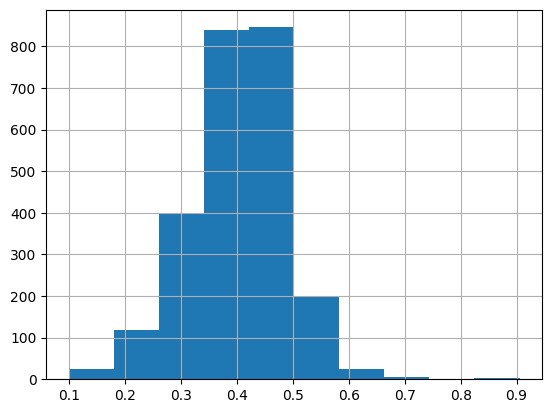

In [18]:
df["is_climate_related"]= df['climate_score']>0.4
df["climate_score"].hist()
print(df["is_climate_related"].value_counts())

In [20]:
df.to_csv('./assets/ANR_DGPIE.csv', sep=";")

# DOS

In [4]:
df = pd.read_csv(os.path.join(root_path,"anr-dos-2005-2009-projets-finances-20240715-projets.csv"),on_bad_lines="warn", sep=";")
df = pd.concat([df, pd.read_csv(os.path.join(root_path,"anr-dos-depuis-2010-projets-finances-20250602-projets.csv"),on_bad_lines="warn", sep=";")])

In [5]:
for col in df.columns :
    print(f"{col} : {df.iloc[56][col]}")

print('--------------------------------')
nan_ratio = df.isna().mean().sort_values(ascending=False)
print(nan_ratio)


Projet.Code_Decision_ANR : ANR-09-TECS-0009
AAP.Edition : 2009
Projet.Acronyme : iPhot
Projet.Titre.Francais : Imagerie clinique des photorécepteurs comme marqueur de la dégénérescence rétinienne
Projet.Titre.Anglais : Imaging of photoreceptors in retinal diseases
Projet.Resume.Francais : Les causes les plus importantes de cécité dans les pays développés sont représentées par les maladies de la rétine. Le diagnostic et le suivi des maladies rétiniennes chez l'homme reposent largement sur l'imagerie de la rétine. Grâce aux progrès de l'opto-électronique, de nouvelles technologies d'imagerie rétiniennes sont apparues en clinique, comme l'ophtalmoscope laser à balayage et la tomographie de coherence optique. Cependant, ces techniques n'autorisent pas à l'heure actuelle une imagerie à l'échelle de la cellule, ce qui est indispensable en particulier pour le diagnostic précoce et le suivi des maladies dégénératives de la rétine. Ces dernières années, l'imagerie par optique adaptative (OA) a 

Axes(0.125,0.11;0.775x0.77)


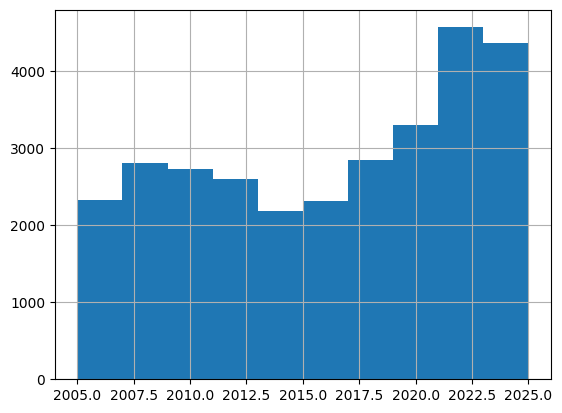

In [6]:
print(df["AAP.Edition"].hist())


In [8]:
df['climate_score'] = df['Projet.Resume.Francais'].progress_apply(
    lambda text: compute_climate_score(text, keyword_embeddings_fr)
)


100%|██████████| 29998/29998 [09:02<00:00, 55.32it/s] 


In [9]:
df["is_climate_related"]= df['climate_score']>0.4

is_climate_related
True     16860
False    13138
Name: count, dtype: int64


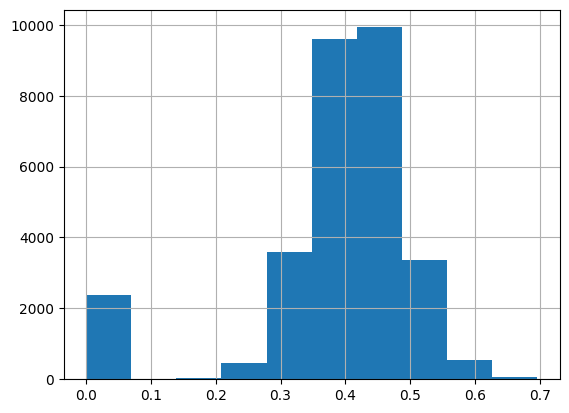

In [10]:
df["climate_score"].hist()
print(df["is_climate_related"].value_counts())

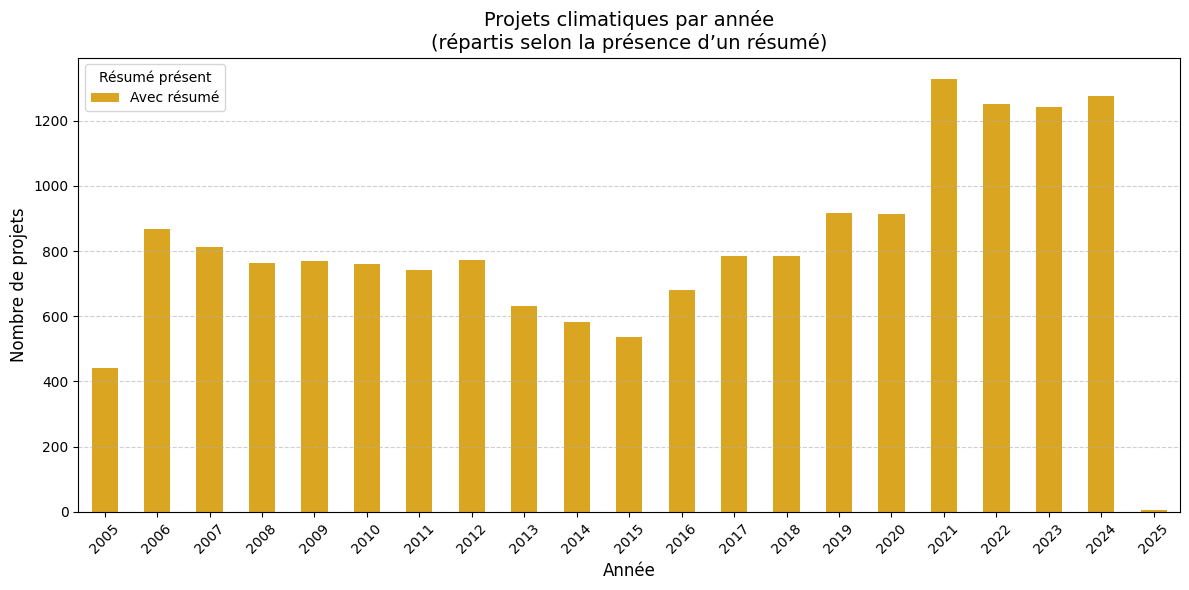

In [13]:
climate_df = df[df["is_climate_related"]].copy()

climate_df["has_resume"] = ~climate_df["Projet.Resume.Francais"].isna()
grouped = climate_df.groupby(["AAP.Edition", "has_resume"]).size().unstack(fill_value=0)

# Renommer seulement si les deux colonnes sont présentes
if set(grouped.columns) == {False, True}:
    grouped.columns = ["Sans résumé", "Avec résumé"]
elif set(grouped.columns) == {False}:
    grouped.columns = ["Sans résumé"]
elif set(grouped.columns) == {True}:
    grouped.columns = ["Avec résumé"]


grouped.sort_index().plot(kind="bar", stacked=False, figsize=(12, 6), color=["goldenrod", "seagreen"])

plt.title("Projets climatiques par année\n(répartis selon la présence d’un résumé)", fontsize=14)
plt.xlabel("Année", fontsize=12)
plt.ylabel("Nombre de projets", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend(title="Résumé présent")
plt.tight_layout()
plt.show()

In [14]:
print(df.columns)

Index(['Projet.Code_Decision_ANR', 'AAP.Edition', 'Projet.Acronyme',
       'Projet.Titre.Francais', 'Projet.Titre.Anglais',
       'Projet.Resume.Francais', 'Projet.Resume.Anglais', 'Programme.Acronyme',
       'Projet.Montant.AF.Aide_allouee.ANR', 'Projet.T0 scientifique',
       'climate_score', 'is_climate_related'],
      dtype='object')


In [15]:
df.to_csv('./assets/ANR_DOS.csv', sep=";")